# Библиотеки




In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from math import *
# from iminuit import Minuit
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.tri as mtri
%pylab inline
import warnings
from scipy import stats
from scipy.integrate import quad
import plotly.express as px
from scipy import stats
from scipy import interpolate
import torch.utils.data as data_utils
warnings.filterwarnings('ignore')
plt.rcParams['font.size']=15


Populating the interactive namespace from numpy and matplotlib


C:\Users\Vasilisa\anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['cos', 'sinh', 'gamma', 'gcd', 'fabs', 'pi', 'fmod', 'sqrt', 'hypot', 'log', 'frexp', 'isclose', 'log1p', 'expm1', 'log10', 'remainder', 'copysign', 'tan', 'trunc', 'e', 'exp', 'tanh', 'ceil', 'nan', 'sin', 'degrees', 'isinf', 'ldexp', 'radians', 'isfinite', 'floor', 'modf', 'log2', 'cosh', 'isnan', 'inf']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Загрузка данных 

In [38]:
# direct='D:/Sphere/approximation/appro_sph/mosaic_hits/sphere-2/QGSJET/10PeV/900/'
# files_N='N/10-20/mh_m01_N_10PeV_10-20_900_01-60'

direct='D:/Sphere/approximation/appro_sph/mosaic_hits/sphere-2/QGSJET_II/10PeV/900/'
files_N='N/10-20/mh_m01_N_10PeV_10-20_900_01-60'

f_coord='D:/Sphere/approximation/appro_sph/mosaic_hits/sphere-2/mosaic_pmt_coords.txt'
coord=pd.read_csv(f_coord,header=None,sep='\s+',names=['n','x','y','z'])   # Загружаю координаты центров каждого ФЭУ
coord['n']=coord['n']-1         # Начинаю отсчет номеров ФЭУ с нуля, как в файлах mosaic_hits_*
coord=coord.drop(columns='z')   # Убираю координату z

def extract_data(f_path):
    data=pd.read_csv(f_path,header=0,sep='\s+',names=['n','x','y','z','t','cosx','cosy','cosz'])
    # ru=data.groupby('n').agg({'n':['count']})  # Ужать до 109 строк.
    # ru=pd.DataFrame({'u':ru['n']['count']})
    # ru['x']=coord['x']
    # ru['y']=coord['y']
    data_clean = data.drop(columns=['x','y','z','cosx','cosy','cosz'])    # Удаляю излишне точные координаты
                                                        # входа фотонов и направляющие косинусы, которые 
                                                        # в эксперименте не фиксируются, это результат подробного моделирования.
    #data_clean = data_clean.merge(coord,on='n')   # Склеиваю файлы с координатами ФЭУ и с фотоэлектронами, чтобы получить x, y - центры ФЭУ.

    # В итоге data_clean состоит из --- ['n','t','x','y']
    return data_clean

# train = data_utils.TensorDataset(df, target)
# train_loader = data_utils.DataLoader(train, batch_size=10, shuffle=True)

# Функция для обработки данных в видеоряд

In [39]:
def video(f_list):
    dt=15  # ns
    stop_cadre=50
    glob_array=[]
    idx=0
    df_n=pd.DataFrame({'n':np.arange(0,121,1)})
    sum_Fe=[]
    for f_path in f_list[:]:
        data=extract_data(f_path)
        data=data.sort_values(['t'])
        cadre=[]
        if (idx+1)%200==0:  print(idx)

        for t in np.arange(data['t'].min(),data['t'].max(),dt): 
            if t < stop_cadre*dt + data['t'].min():
                # d_data=data[(data['t']>t)&(data['t']<t+dt)]   # Отрезок массива в 15 сек
                df_n=pd.DataFrame({'n':np.arange(0,121,1)})    # Список из номеров ФЭУ    ==121==

                d_n_count=data[(data['t']>t)&(data['t']<t+dt)].groupby('n').agg({'n':['count']})['n']   # кол-во активаций и в каких ФЭУ
                df_n_count=pd.DataFrame({'n':d_n_count['count'].index,'c':d_n_count['count'].to_numpy()}) 

                df=df_n.merge(df_n_count,on='n',how='left').drop(columns='n').fillna(0)  # Список из активаций ФЭУ, номера ФЭУ по порядку (по индексу)

                cadre.append(df.to_numpy().reshape(-1))

        if t < stop_cadre*dt + data['t'].min():     # До 75 кадров доходим
            add_to=int(stop_cadre-(t-data['t'].min())/dt-1)   # Тут -1 есть!
            [cadre.append(np.zeros(121))  for i in range(add_to)]   #    ==121==
        cadre=np.array(cadre).reshape(stop_cadre,11,11,1)
        idx+=1

                  
        glob_array.append(cadre)
    glob_array=np.array(glob_array)         # Возвращает массив [6000,50,11,11,1] , 6000 - число событий, 75 - число кадров, 11х11 - сетка детекторов ФЭУ, из них активируются только 109.
    return glob_array

In [40]:
f_list=list(Path(direct+files_N).glob('mos*'))   # Менять q and type_particle!
glob_array=video(f_list)
np.save((direct+'glob_array_N_q2.npy'),np.array(glob_array).reshape(-1))   # Менять q and type_particle!

199
399
599
799
999
1199
1399
1599
1799
1999
2199
2399
2599
2799
2999
3199
3399
3599
3799
3999
4199
4399
4599
4799
4999
5199
5399
5599
5799
5999


# Функция для обработки в две карты, по среднему времени и числу фотонов (две 2D карты, таких 6000 штук) 

In [41]:
def map2D(f_list):
    df_num=pd.DataFrame({'n':np.arange(0,121,1)})
    df_11=[]
    df_11t=[]
    idx=0
    for f_path in f_list[:]:
        data=extract_data(f_path)
        if (idx+1)%200==0:  print(idx)

        d_num_count=data.groupby('n').agg({'n':['count']})['n']
        df_num_count=pd.DataFrame({'n':d_num_count['count'].index,'count':d_num_count['count'].to_numpy()})
        # df_num_count['count']=(df_num_count['count']-min(df_num_count['count']))/(df_num_count['count'].max()-df_num_count['count'].min())    # Нормализую данные по кол-ву фотонов в ФЭУ
        df_11.append(np.array(df_num.merge(df_num_count,on='n',how='left').drop(columns='n').fillna(0)).reshape(-1))

        data['t']=(data['t']-min(data['t']))/(data['t'].max()-data['t'].min())  # Нормализую данные по времени
        d_t_mean=data.groupby('n').agg({'t':['mean']})
        df_t_mean=pd.DataFrame({'n':d_t_mean['t'].index,'mean':d_t_mean['t']['mean'].to_numpy()})
        df_11t.append(np.array(df_num.merge(df_t_mean,on='n',how='left').drop(columns='n').fillna(0)).reshape(-1))
        idx+=1
    # print(df_num_count.shape)
    df_11=(np.array(df_11))
    df_11t=(np.array(df_11t))
    df_2map=np.dstack((df_11,df_11t))
    return df_2map

In [42]:
f_list=list(Path(direct+files_N).glob('mos*'))     # Менять q and type_particle!

df_2map=map2D(f_list)
df_2map=df_2map.reshape(6000,11,11,2)

np.save(Path.cwd()/(direct+'map2_N.npy'),np.array(df_2map).reshape(-1))           # SAVING FILE !     # Менять q and type_particle!

KeyboardInterrupt: 

In [ ]:
df_2map

array([[[[1.00000000e+01, 8.19060078e-02],
         [5.00000000e+00, 1.14259837e-01],
         [1.20000000e+01, 5.99946329e-02],
         ...,
         [1.30000000e+01, 1.77394508e-01],
         [6.00000000e+00, 1.24953876e-01],
         [5.00000000e+00, 2.02475596e-01]],

        [[6.00000000e+00, 1.29666901e-01],
         [2.00000000e+00, 1.61517561e-01],
         [5.00000000e+00, 1.85790480e-01],
         ...,
         [1.90000000e+01, 1.78159245e-01],
         [2.10000000e+01, 1.54233576e-01],
         [1.60000000e+01, 1.85606823e-01]],

        [[1.50000000e+01, 2.17302338e-01],
         [8.00000000e+00, 2.18350609e-01],
         [7.00000000e+00, 2.10037522e-01],
         ...,
         [4.00000000e+00, 2.26829023e-01],
         [1.00000000e+00, 4.72375969e-01],
         [2.00000000e+00, 2.94907920e-01]],

        ...,

        [[7.00000000e+00, 4.73094783e-01],
         [1.00000000e+01, 4.40837275e-01],
         [2.90000000e+01, 4.70200192e-01],
         ...,
         [5.00000000e

## Вариант с размерностью 2,11,11

In [43]:
def map2D(f_list):
    df_num=pd.DataFrame({'n':np.arange(0,121,1)})
    df_11=[]
    df_11t=[]
    df_2map=[]
    idx=0
    for f_path in f_list[:]:
        data=extract_data(f_path)
        if (idx+1)%200==0:  print(idx)

        d_num_count=data.groupby('n').agg({'n':['count']})['n']
        df_num_count=pd.DataFrame({'n':d_num_count['count'].index,'count':d_num_count['count'].to_numpy()})
        df_11=(np.array(df_num.merge(df_num_count,on='n',how='left').drop(columns='n').fillna(0)).reshape(-1)).tolist()
        # df_num_count['count']=(df_num_count['count']-min(df_num_count['count']))/(df_num_count['count'].max()-df_num_count['count'].min())    # Нормализую данные по кол-ву фотонов в ФЭУ
        # df_11.append(np.array(df_num.merge(df_num_count,on='n',how='left').drop(columns='n').fillna(0)).reshape(-1))

        data['t']=(data['t']-min(data['t']))/(data['t'].max()-data['t'].min())  # Нормализую данные по времени, ибо каждое событие должно начинаться с 0!
        d_t_mean=data.groupby('n').agg({'t':['mean']})
        df_t_mean=pd.DataFrame({'n':d_t_mean['t'].index,'mean':d_t_mean['t']['mean'].to_numpy()})
        df_11t=(np.array(df_num.merge(df_t_mean,on='n',how='left').drop(columns='n').fillna(0)).reshape(-1)).tolist()
        # df_11t.append(np.array(df_num.merge(df_t_mean,on='n',how='left').drop(columns='n').fillna(0)).reshape(-1))
        df_2map.append([df_11,df_11t])
        idx+=1
    # print(df_num_count.shape)
    # df_2map=[df_11,df_11t]
    return df_2map

In [44]:
# direct='drive/MyDrive/mosaic_hits/sphere-2/QGSJET/10PeV/900/15/'
# files_p='p/mh_m01_900_p_10PeV_15_001-060'
# files_N='N/mh_m01_900_N_10PeV_15_001-060'
# files_Fe='Fe/mh_m01_900_Fe_10PeV_15_001-060'

f_list=list(Path(direct+files_N).glob('mos*'))      # Менять q and type_particle!

df_2map=np.array(map2D(f_list))
df_2map=df_2map.reshape(df_2map.shape[0],2,11,11)
df_2map.shape

np.save(Path.cwd()/(direct+'map2_N_q2.npy'),df_2map.reshape(-1))           # SAVING FILE !     # Менять q and type_particle!

199
399
599
799
999
1199
1399
1599
1799
1999
2199
2399
2599
2799
2999
3199
3399
3599
3799
3999
4199
4399
4599
4799
4999
5199
5399
5599
5799
5999


In [ ]:
map_load=np.load(direct+'map2_N.npy')
map_load=map_load.reshape(6000,2,11,11)
map_load

array([[[[1.00000000e+01, 5.00000000e+00, 1.20000000e+01, ...,
          1.30000000e+01, 6.00000000e+00, 5.00000000e+00],
         [6.00000000e+00, 2.00000000e+00, 5.00000000e+00, ...,
          1.90000000e+01, 2.10000000e+01, 1.60000000e+01],
         [1.50000000e+01, 8.00000000e+00, 7.00000000e+00, ...,
          4.00000000e+00, 1.00000000e+00, 2.00000000e+00],
         ...,
         [7.00000000e+00, 1.00000000e+01, 2.90000000e+01, ...,
          5.00000000e+00, 3.00000000e+00, 1.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 4.00000000e+00, ...,
          6.00000000e+00, 6.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

        [[7.98899900e+04, 7.99221400e+04, 7.98682167e+04, ...,
          7.99848769e+04, 7.99327667e+04, 8.00098000e+04],
         [7.99374500e+04, 7.99691000e+04, 7.99932200e+04, ...,
          7.99856368e+04, 7.99618619e+04, 7.99930375e+04],
        

## Иллюстрация кол-ва фотонов 3D 

(6000, 2, 121)


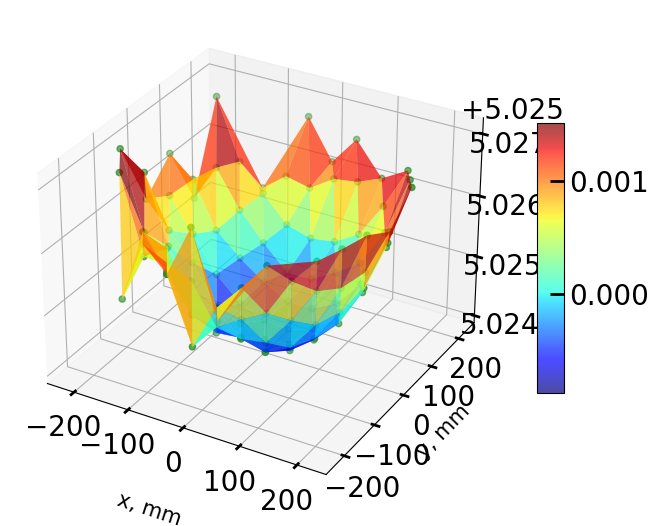

In [ ]:
import matplotlib.tri as mtri

# direct='drive/MyDrive/mosaic_hits/sphere-2/QGSJET/10PeV/900/15/'
# files_p='p/mh_m01_900_p_10PeV_15_001-060'
# files_N='N/mh_m01_900_N_10PeV_15_001-060'
# files_Fe='Fe/mh_m01_900_Fe_10PeV_15_001-060'  

def extract_map_data(f_path):
    data=np.load(f_path).reshape(6000,2,121)
    print(data.shape)
    data=data[100][1]
    I=data[:109]
    ru=pd.DataFrame({'I':I})
    ru['x']=coord['x']
    ru['y']=coord['y']
    return ru
    
df = extract_map_data(direct+'map2_N.npy')
x,y,I=df['x'],df['y'],df['I']   

triang = mtri.Triangulation(x, y)

fig = plt.figure(figsize=(8,7))
ax = fig.add_subplot( projection='3d')
# surf = ax.plot_surface(X, Y, np.log10(func(p0,p1,p2,p3,p4,s,x0,y0,X,Y)),alpha=0.7,cmap='jet',label='fit')
ax.scatter(x,y,np.log10(I),color='forestgreen',label='LDF')
surf=ax.plot_trisurf(triang, np.log10(I),alpha=0.7,cmap='jet',label='fit')
plt.xlabel(' x, mm',fontsize = 15)
plt.ylabel(' y, mm',fontsize = 15)
ax.xaxis.labelpad = 20
fig.colorbar(surf, shrink=0.5, aspect=10)

# plt.savefig('graphs_LDF_'+str(int(idx))+'.png'),bbox_inches='tight')

## 2D вид сверху

(6000, 2, 121)


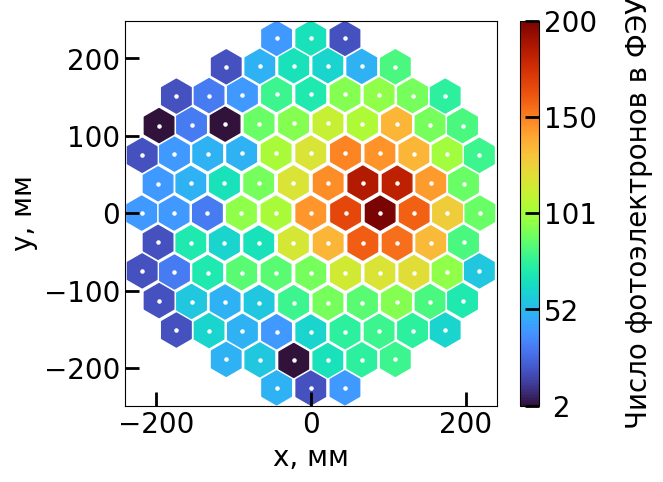

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

df = extract_map_data(direct+'map2_N.npy')
x,y,I=df['x'],df['y'],df['I']   
    
fig=plt.figure(figsize=(6,5))
I=np.log10(I)  #!!! LOG 10 !!!

cax=plt.scatter(x,y,c=I,cmap='turbo',marker='h',s=600)
plt.scatter(x,y,c='white',marker='o',s=5)

lg_tick=np.linspace(I.min(),I.max(),5, endpoint=True)
# v1 = np.linspace(10**(I).min(), 10**(I).max(), 5, endpoint=True)
v1 = np.linspace(10**(I).min(), 200, 5, endpoint=True)

cbar=plt.colorbar(cax,ticks=lg_tick) #ticks=[0, 1, 2])
cbar.ax.set_yticklabels(["{:2.0f}".format(i) for i in v1])
cbar.ax.set_ylabel('Число фотоэлектронов в ФЭУ',fontsize=20)
cbar.ax.get_yaxis().labelpad = 20

plt.xlabel('x, мм',fontsize=20)
plt.ylabel('y, мм',fontsize=20)
# plt.savefig('drive/MyDrive/mosaic_hits/fpr_size_log_dot.png',bbox_inches='tight')

## 2D картинка для времени

(6000, 2, 121)


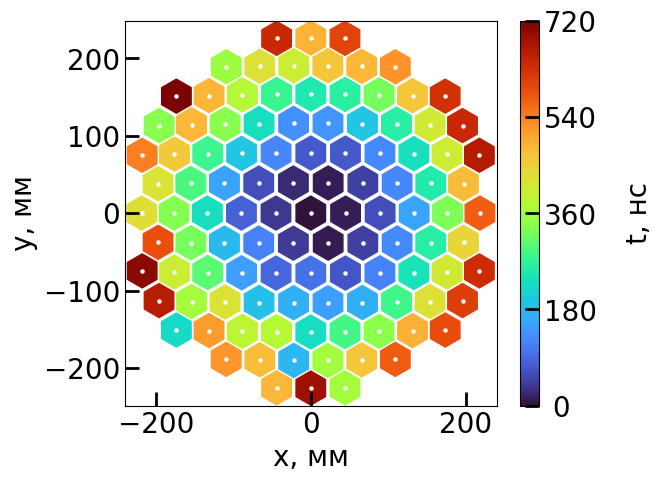

In [ ]:
df = extract_map_data(direct+'map2_N.npy')
x,y,I=df['x'],df['y'],df['I']   
    
fig=plt.figure(figsize=(6,5))
I=np.log10(I)  #!!! LOG 10 !!!

cax=plt.scatter(x,y,c=I,cmap='turbo',marker='h',s=600)
plt.scatter(x,y,c='white',marker='o',s=5)

lg_tick=np.linspace(I.min(),I.max(),5, endpoint=True)
# v1 = np.linspace(10**(I).min(), 10**(I).max(), 5, endpoint=True)
v1 = np.linspace(0,10**(I).max()-10**(I).min(), 5, endpoint=True)

cbar=plt.colorbar(cax,ticks=lg_tick) #ticks=[0, 1, 2])
cbar.ax.set_yticklabels(["{:2.0f}".format(i) for i in v1])
cbar.ax.set_ylabel('t, нс',fontsize=20)
cbar.ax.get_yaxis().labelpad = 20

plt.xlabel('x, мм',fontsize=20)
plt.ylabel('y, мм',fontsize=20)
# plt.savefig('drive/MyDrive/mosaic_hits/time_log_dot.png',bbox_inches='tight')

# Проверка загруженных файлов

In [ ]:
p=np.load( direct+'work/glob_array.npy')   
p=p.reshape(6000,75,11,11,1)
p

array([46., 23., 18., ...,  0.,  0.,  0.])

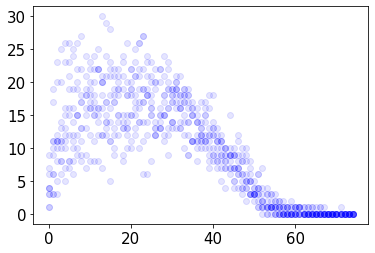

In [ ]:
fig=plt.figure()
stop_cadre75
for j in range(10):
  for i in range(stop_cadre):
    plt.scatter(i,np.count_nonzero(p[j,i,:,:]),color='blue',alpha=0.1)
# plt.savefig('nonzero_cadre.png')

## Для файлов протнов

Оптимальное число кадров 50 по 15 сек, потому что дальше активаций ФЭУ меньше 5 штук.

In [ ]:
f_list=list(Path(direct+files_p).glob('mos*'))
dt=15  # ns
stop_cadre=75
glob_array_p=[]
# l=[]
idx=0
df_n=pd.DataFrame({'n':np.arange(0,121,1)})

for f_path in f_list[:]:
    data=extract_data(f_path)
    data=data.sort_values(['t'])
    cadre=[]
    # l.append((data['t'].max()-data['t'].min())/dt)
    if (idx+1)%200==0:  print(idx)
    
    for t in np.arange(data['t'].min(),data['t'].max(),dt): 
        if t < stop_cadre*dt + data['t'].min():
            # d_data=data[(data['t']>t)&(data['t']<t+dt)]   # Отрезок массива в 15 сек
            # df_n=pd.DataFrame({'n':np.arange(0,121,1)})    # Список из номеров ФЭУ    ==121==

            d_n_count=data[(data['t']>t)&(data['t']<t+dt)].groupby('n').agg({'n':['count']})['n']   # кол-во активаций и в каких ФЭУ
            df_n_count=pd.DataFrame({'n':d_n_count['count'].index,'c':d_n_count['count'].to_numpy()}) 

            df=df_n.merge(df_n_count,on='n',how='left').drop(columns='n').fillna(0)  # Список из активаций ФЭУ, номера ФЭУ по порядку (по индексу)

            cadre.append(df.to_numpy().reshape(-1))
            # print(max(df.to_numpy()),len(df_n_count))
    # print(idx,(data['t'].max()-data['t'].min())/dt)

    if t < stop_cadre*dt + data['t'].min():     # До 75 кадров доходим
        add_to=int(stop_cadre-(t-data['t'].min())/dt-1)   # Тут -1 есть!
        # print(add_to)
        [cadre.append(np.zeros(121))  for i in range(add_to)]   #    ==121==
    cadre=np.array(cadre).reshape(stop_cadre,11,11,1)
    # print(np.array(cadre).shape)
    idx+=1
              
    glob_array_p.append(cadre)
glob_array_p=np.array(glob_array_p)

# np.save(Path.cwd()/(direct+'glob_array_pro_q1.npy'),np.array(glob_array_p).reshape(-1))     # SAVING FILE !

## Делаю карту числа попаданий фотонов  в ФЭУ

In [ ]:
f_list=list(Path(direct+files_p).glob('mos*'))

def main(f_list):
    df_num=pd.DataFrame({'n':np.arange(0,121,1)})
    df_11=[]
    df_11t=[]
    idx=0
    for f_path in f_list[:]:
        data=extract_data(f_path)
        if (idx+1)%200==0:  print(idx)

        d_num_count=data.groupby('n').agg({'n':['count']})['n']
        df_num_count=pd.DataFrame({'n':d_num_count['count'].index,'count':d_num_count['count'].to_numpy()})
        df_11.append(np.array(df_num.merge(df_num_count,on='n',how='left').drop(columns='n').fillna(0)).reshape(-1))

        data['t']=(data['t']-min(data['t']))/(data['t'].max()-data['t'].min())  # Нормализую данные по времени
        d_t_mean=data.groupby('n').agg({'t':['mean']})
        df_t_mean=pd.DataFrame({'n':d_t_mean['t'].index,'mean':d_t_mean['t']['mean'].to_numpy()})
        df_11t.append(np.array(df_num.merge(df_t_mean,on='n',how='left').drop(columns='n').fillna(0)).reshape(-1))
        idx+=1
    # print(df_num_count)
    df_11=(np.array(df_11))
    df_11t=(np.array(df_11t))
    df_2map=np.dstack((df_11,df_11t))
    return df_2map

f_list=list(Path(direct+files_p).glob('mos*'))

df_2map_p=main(f_list)
df_2map_p=df_2map_p.reshape(6000,11,11,2)
# df_2map_p
# np.save(Path.cwd()/(direct+'map2_p.npy'),np.array(df_2map_p).reshape(-1))           # SAVING FILE !

199
399
599
799
999
1199
1399
1599
1799
1999
2199
2399
2599
2799
2999
3199
3399
3599
3799
3999
4199
4399
4599
4799
4999
5199
5399
5599
5799
5999


array([[[[6.20000000e+01, 1.30544206e-02],
         [1.58000000e+02, 3.04098470e-02],
         [8.10000000e+01, 2.90148325e-02],
         ...,
         [2.34000000e+02, 6.21016554e-02],
         [7.50000000e+01, 8.70957388e-02],
         [3.40000000e+01, 7.33025450e-02]],

        [[1.60000000e+01, 1.18508647e-01],
         [1.60000000e+01, 1.02848334e-01],
         [1.40000000e+01, 1.40955095e-01],
         ...,
         [1.46000000e+02, 1.75767679e-01],
         [2.11000000e+02, 1.25050586e-01],
         [1.04000000e+02, 1.40472294e-01]],

        [[3.70000000e+01, 1.90517038e-01],
         [1.80000000e+01, 1.72747917e-01],
         [1.50000000e+01, 1.60282991e-01],
         ...,
         [9.00000000e+00, 1.85931239e-01],
         [1.10000000e+01, 3.13871743e-01],
         [1.00000000e+01, 1.81202712e-01]],

        ...,

        [[1.30000000e+01, 4.11070211e-01],
         [2.10000000e+01, 3.98620606e-01],
         [2.20000000e+01, 4.15361734e-01],
         ...,
         [4.00000000e

# Проверка загрузки 2D карт

In [ ]:
map2=np.load( direct+'map2_p.npy')   
map2.reshape(6000,11,11,2)

array([[[[5.70000000e+01, 1.68344627e-02],
         [1.33000000e+02, 2.97760251e-02],
         [1.03000000e+02, 3.12785928e-02],
         ...,
         [1.92000000e+02, 7.21601835e-02],
         [7.90000000e+01, 1.03616208e-01],
         [2.50000000e+01, 8.52016390e-02]],

        [[1.60000000e+01, 1.12707570e-01],
         [2.20000000e+01, 9.42566707e-02],
         [1.30000000e+01, 1.45062292e-01],
         ...,
         [1.29000000e+02, 2.02856866e-01],
         [2.02000000e+02, 1.39360653e-01],
         [1.20000000e+02, 1.52653476e-01]],

        [[4.00000000e+01, 2.02091870e-01],
         [2.30000000e+01, 1.73688010e-01],
         [1.50000000e+01, 1.75264179e-01],
         ...,
         [1.70000000e+01, 1.95067805e-01],
         [7.00000000e+00, 2.86022367e-01],
         [6.00000000e+00, 2.00003594e-01]],

        ...,

        [[1.60000000e+01, 4.38854593e-01],
         [2.60000000e+01, 4.54562798e-01],
         [1.90000000e+01, 5.07116670e-01],
         ...,
         [3.00000000e

## Делаю карту среднего времени активации ФЭУ

In [ ]:
def main(f_list):
    df_num=pd.DataFrame({'n':np.arange(0,121,1)})
    df_11t=[]
    for f_path in f_list[:2]:
        data=extract_data(f_path)
        min_t=data['t'].min()
        data['t']-=min_t
        data['t']=(data['t']-min(data['t']))/(data['t'].max()-data['t'].min())
        d_t_mean=data.groupby('n').agg({'t':['mean']})
        df_t_mean=pd.DataFrame({'n':d_t_mean['t'].index,'c':d_t_mean['t']['mean'].to_numpy()})
        df_11t.append(np.array(df_num.merge(df_t_mean,on='n',how='left').drop(columns='n').fillna(0)).reshape(-1))
    df_11t=np.array(df_11t)
    return df_11t

f_list=list(Path(direct+files_p).glob('mos*'))
df_11t=main(f_list)
df_11t

array([[0.01683446, 0.02977603, 0.03127859, 0.04665161, 0.06029761,
        0.04715949, 0.0403498 , 0.08855299, 0.07216018, 0.10361621,
        0.08520164, 0.11270757, 0.09425667, 0.14506229, 0.13484608,
        0.12866616, 0.08851936, 0.12947243, 0.07492648, 0.20285687,
        0.13936065, 0.15265348, 0.20209187, 0.17368801, 0.17526418,
        0.21844943, 0.21281463, 0.19514091, 0.27147581, 0.17063834,
        0.1950678 , 0.28602237, 0.20000359, 0.17795107, 0.21443462,
        0.16335768, 0.1568012 , 0.3704756 , 0.27702491, 0.26766993,
        0.31110745, 0.34141821, 0.2957541 , 0.31948338, 0.32488678,
        0.38873463, 0.36474013, 0.28884516, 0.3478003 , 0.31567516,
        0.31624853, 0.28391201, 0.33721965, 0.4653871 , 0.3434063 ,
        0.33135648, 0.33681259, 0.3890716 , 0.31246164, 0.30571692,
        0.27866708, 0.63030515, 0.50630197, 0.43953077, 0.4331413 ,
        0.49282295, 0.59286895, 0.50924243, 0.4942851 , 0.43296672,
        0.51071814, 0.60499784, 0.53199806, 0.49

# График активации ФЭУ от времени

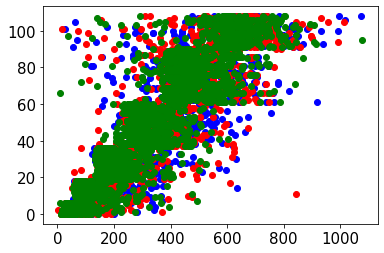

In [ ]:
def main(f_list):
    df_num=pd.DataFrame({'n':np.arange(0,121,1)})
    df_11=[]
    for f_path in f_list[:20]:
        data=extract_data(f_path)
        min_t=data['t'].min()
        data['t']-=min_t
        d_num_count=data.groupby('n').agg({'t':['mean']})
        
        plt.scatter(d_num_count['t']['mean'], d_num_count['t'].index, color=col, label=lab)

    
# График активации ФЭУ от времени
fig=plt.figure()
col=['blue']
lab='p'
f_list=list(Path(direct+files_p).glob('mos*'))
main(f_list)

col=['red']
lab='N'
f_list=list(Path(direct+files_N).glob('mos*'))
main(f_list)

col=['green']
lab='Fe'
f_list=list(Path(direct+files_Fe).glob('mos*'))
main(f_list)

# plt.legend()

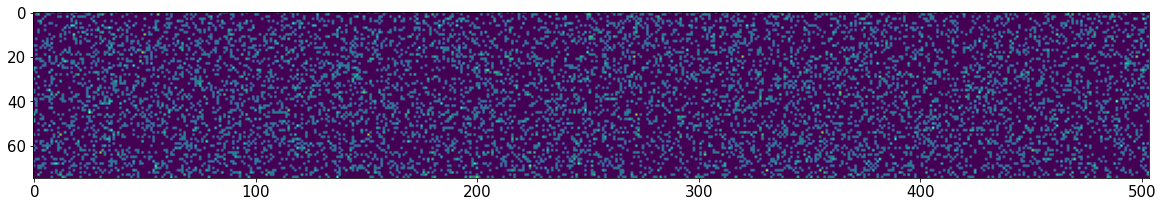

In [ ]:
import math


a = np.random.randint(0, 504, size = (100,75,11*11))
hist_int = np.zeros((75, 504))

for t in range(75):
    unique, counts = np.unique(a[0][t], return_counts=True)
    val_int = dict(zip(unique, counts))
    for k in range(504):
        hist_int[t, k] = math.log(1 + val_int.get(k, 0))

hist_int /= np.max(hist_int)
plt.figure(figsize=(20,20))
plt.imshow(hist_int)


## Для файлов Азота

In [ ]:
f_list=list(Path(direct+files_N).glob('mos*'))
dt=15  # ns
stop_cadre=75
glob_array_N=[]
idx=0
df_n=pd.DataFrame({'n':np.arange(0,121,1)})

for f_path in f_list[:]:
    data=extract_data(f_path)
    data=data.sort_values(['t'])
    cadre=[]
    if (idx+1)%200==0:  print(idx)

    for t in np.arange(data['t'].min(),data['t'].max(),dt): 
        if t < stop_cadre*dt + data['t'].min():
            # d_data=data[(data['t']>t)&(data['t']<t+dt)]   # Отрезок массива в 15 сек
            # df_n=pd.DataFrame({'n':np.arange(0,121,1)})    # Список из номеров ФЭУ    ==121==

            d_n_count=data[(data['t']>t)&(data['t']<t+dt)].groupby('n').agg({'n':['count']})['n']   # кол-во активаций и в каких ФЭУ
            df_n_count=pd.DataFrame({'n':d_n_count['count'].index,'c':d_n_count['count'].to_numpy()}) 

            df=df_n.merge(df_n_count,on='n',how='left').drop(columns='n').fillna(0)  # Список из активаций ФЭУ, номера ФЭУ по порядку (по индексу)

            cadre.append(df.to_numpy().reshape(-1))

    if t < stop_cadre*dt + data['t'].min():     # До 75 кадров доходим
        add_to=int(stop_cadre-(t-data['t'].min())/dt-1)   # Тут -1 есть!
        [cadre.append(np.zeros(121))  for i in range(add_to)]   #    ==121==
    cadre=np.array(cadre).reshape(stop_cadre,11,11,1)
    idx+=1

              
    glob_array_N.append(cadre)
glob_array_N=np.array(glob_array_N)

199
399
599
799
999
1199
1399
1599
1799
1999
2199
2399
2599
2799


KeyboardInterrupt: ignored

In [ ]:
np.save(Path.cwd()/(direct+'glob_array_N_q1.npy'),np.array(glob_array_N).reshape(-1))

dataspell

## Для файлов Железа

In [ ]:
f_list=list(Path(direct+files_Fe).glob('mos*'))
dt=15  # ns
stop_cadre=75
glob_array_Fe=[]
idx=0
df_n=pd.DataFrame({'n':np.arange(0,121,1)})
sum_Fe=[]
for f_path in f_list[:]:
    data=extract_data(f_path)
    # data=data.sort_values(['t'])
    cadre=[]
    if (idx+1)%200==0:  print(idx)
    sum_Fe.append(np.count_nonzero(data['n']))


In [ ]:
sum(~np.array([np.array(sum_Fe)[i]<2000 for i in range(6000)]))

821

In [ ]:
f_list=list(Path(direct+files_Fe).glob('mos*'))
dt=15  # ns
stop_cadre=75
glob_array_Fe=[]
idx=0
df_n=pd.DataFrame({'n':np.arange(0,121,1)})
sum_Fe=[]
for f_path in f_list[:]:
    data=extract_data(f_path)
    data=data.sort_values(['t'])
    cadre=[]
    if (idx+1)%200==0:  print(idx)

    for t in np.arange(data['t'].min(),data['t'].max(),dt): 
        if t < stop_cadre*dt + data['t'].min():
            # d_data=data[(data['t']>t)&(data['t']<t+dt)]   # Отрезок массива в 15 сек
            df_n=pd.DataFrame({'n':np.arange(0,121,1)})    # Список из номеров ФЭУ    ==121==

            d_n_count=data[(data['t']>t)&(data['t']<t+dt)].groupby('n').agg({'n':['count']})['n']   # кол-во активаций и в каких ФЭУ
            df_n_count=pd.DataFrame({'n':d_n_count['count'].index,'c':d_n_count['count'].to_numpy()}) 

            df=df_n.merge(df_n_count,on='n',how='left').drop(columns='n').fillna(0)  # Список из активаций ФЭУ, номера ФЭУ по порядку (по индексу)

            cadre.append(df.to_numpy().reshape(-1))

    if t < stop_cadre*dt + data['t'].min():     # До 75 кадров доходим
        add_to=int(stop_cadre-(t-data['t'].min())/dt-1)   # Тут -1 есть!
        [cadre.append(np.zeros(121))  for i in range(add_to)]   #    ==121==
    cadre=np.array(cadre).reshape(stop_cadre,11,11,1)
    idx+=1

              
    glob_array_Fe.append(cadre)
glob_array_Fe=np.array(glob_array_Fe)

199
399
599
799
999
1199
1399
1599
1799
1999
2199
2399
2599
2799
2999
3199
3399
3599
3799
3999
4199
4399
4599
4799
4999
5199
5399
5599
5799
5999


In [ ]:
np.save(Path.cwd()/(direct+'glob_array_Fe_q2.npy'),np.array(glob_array_Fe).reshape(-1))

# Проверка

Проверяю насоколько много кадров хранят в себе полезную информацию

In [ ]:
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.direction'] = 'in' 

plt.rcParams['xtick.major.size']=10
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['xtick.minor.width'] = 1
# plt.rcParams['xtick.minor.visible'] = 'True'

plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['ytick.minor.width'] = 1

plt.rcParams.update({'font.size':20})
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)

In [ ]:
direct='drive/MyDrive/mosaic_hits/sphere-2/QGSJET/10PeV/900/15/'
p=np.load( direct+'data_to_NN/glob_array_p_q1.npy')   
p=p.reshape(6000,75,11,11,1)
# p

In [ ]:
from ast import Pass
# from google.colab import drive
# drive.mount('/content/drive')
direct_q1='drive/MyDrive/mosaic_hits/sphere-2/QGSJET/10PeV/900/15/data_to_NN/'
direct_q2='drive/MyDrive/mosaic_hits/sphere-2/QGSJET_II/10PeV/900/15/data_to_NN/'

data_direct=[direct_q1+'glob_array_p_q1.npy',direct_q1+'glob_array_N_q1.npy',direct_q1+'glob_array_Fe_q1.npy',\
             direct_q2+'glob_array_p_q2.npy',direct_q2+'glob_array_N_q2.npy',direct_q2+'glob_array_Fe_q2.npy']
map_direct=[direct_q1+'map2_p.npy',direct_q1+'map2_N.npy',direct_q1+'map2_Fe.npy',\
             direct_q2+'map2_p.npy',direct_q2+'map2_N.npy',direct_q2+'map2_Fe.npy']

border=1200   # граница числа фотонов, если их в сумме зарегистрировалось меньше в одном событии, то такое событие не рассматривается.
data_all,data_2D,data_y,data_y_int,data_noise=[],[],[],[],[]
target_num=[0,1,2,0,1,2]
# target_mass=[ln_m[0],ln_m[1],ln_m[2],ln_m[0],ln_m[1],ln_m[2]]
for i in range(6):

    particle_data=np.load( data_direct[i])   
    particle_data=particle_data.reshape(6000,75,11,11,1)
    
    # Обрезаем данные
    # bool_mask=[sum(particle_data[i])<border for i in range(6000)]
    # particle_data=particle_data[~np.array(bool_mask)]
    # particle_data = particle_data[:,:50]
    # print(particle_data.min() ,particle_data.max())

    map2D=np.load( map_direct[i])   
    map2D=map2D.reshape(6000,11,11,2)
    # map2D=map2D[~np.array(bool_mask)]
    # print(map2D.min(),map2D.max())

    data_all.append(particle_data)
    data_2D.append(map2D)
    data_y_int.append([target_num[i]]*particle_data.shape[0])    # В качетсве y целые числа, 0, 1, 2 
    # data_y.append([target_mass[i]]*particle_data.shape[0])     # В качетсве y действительные числа, логарифма массы соответствующих ядер


In [ ]:
data_map=data_2D[0][0]
data_map

array([[[6.20000000e+01, 1.30544206e-02],
        [1.58000000e+02, 3.04098470e-02],
        [8.10000000e+01, 2.90148325e-02],
        [2.80000000e+01, 4.23995283e-02],
        [2.00000000e+01, 5.99734696e-02],
        [2.90000000e+01, 5.11532089e-02],
        [4.50000000e+01, 3.92060529e-02],
        [3.50000000e+02, 7.84180014e-02],
        [2.34000000e+02, 6.21016554e-02],
        [7.50000000e+01, 8.70957388e-02],
        [3.40000000e+01, 7.33025450e-02]],

       [[1.60000000e+01, 1.18508647e-01],
        [1.60000000e+01, 1.02848334e-01],
        [1.40000000e+01, 1.40955095e-01],
        [2.20000000e+01, 9.25303938e-02],
        [1.80000000e+01, 1.08812901e-01],
        [2.50000000e+01, 8.03222954e-02],
        [3.60000000e+01, 9.41474785e-02],
        [1.25000000e+02, 6.18248993e-02],
        [1.46000000e+02, 1.75767679e-01],
        [2.11000000e+02, 1.25050586e-01],
        [1.04000000e+02, 1.40472294e-01]],

       [[3.70000000e+01, 1.90517038e-01],
        [1.80000000e+01, 1.727

In [ ]:
data_map=data_2D[0].reshape(data_2D[0].shape[0],2,11,11)
data_map[0]

array([[[6.20000000e+01, 1.30544206e-02, 1.58000000e+02, 3.04098470e-02,
         8.10000000e+01, 2.90148325e-02, 2.80000000e+01, 4.23995283e-02,
         2.00000000e+01, 5.99734696e-02, 2.90000000e+01],
        [5.11532089e-02, 4.50000000e+01, 3.92060529e-02, 3.50000000e+02,
         7.84180014e-02, 2.34000000e+02, 6.21016554e-02, 7.50000000e+01,
         8.70957388e-02, 3.40000000e+01, 7.33025450e-02],
        [1.60000000e+01, 1.18508647e-01, 1.60000000e+01, 1.02848334e-01,
         1.40000000e+01, 1.40955095e-01, 2.20000000e+01, 9.25303938e-02,
         1.80000000e+01, 1.08812901e-01, 2.50000000e+01],
        [8.03222954e-02, 3.60000000e+01, 9.41474785e-02, 1.25000000e+02,
         6.18248993e-02, 1.46000000e+02, 1.75767679e-01, 2.11000000e+02,
         1.25050586e-01, 1.04000000e+02, 1.40472294e-01],
        [3.70000000e+01, 1.90517038e-01, 1.80000000e+01, 1.72747917e-01,
         1.50000000e+01, 1.60282991e-01, 1.30000000e+01, 2.44744938e-01,
         1.40000000e+01, 1.55785455e-0

In [ ]:
br = [[[5.37692693e+03, 3.78425697e-03],  [1.36092539e+03, 3.35722632e-03],  [5.43477586e+03, 3.90104194e-03],  [5.93759455e+03, 4.05490440e-03],  [3.00855802e+03, 3.65746871e-03],  [4.69875286e+03, 3.93713784e-03]]]

x10,x11 = zip(*br[0])
print(x10,x11) 

(5376.92693, 1360.92539, 5434.77586, 5937.59455, 3008.55802, 4698.75286) (0.00378425697, 0.00335722632, 0.00390104194, 0.0040549044, 0.00365746871, 0.00393713784)


In [ ]:
np.array(br).shape

(1, 6, 2)

In [ ]:
data0=data_map #data_2D[0]
data0.shape

(11, 11, 2)

In [ ]:
x1 = np.array([np.array(list([*zip(*data0[i])])) for i in range(11)])
x1.shape

In [ ]:
x1 = [(list(zip(*data0[i]))) for i in range(11)]
x2=np.array(list(zip(*x1)))
x2.shape

[(62.0, 158.0, 81.0, 28.0, 20.0, 29.0, 45.0, 350.0, 234.0, 75.0, 34.0),
 (0.013054420625889027,
  0.03040984697437652,
  0.029014832526018084,
  0.04239952834823573,
  0.059973469588287344,
  0.05115320889226169,
  0.03920605286430181,
  0.07841800137565112,
  0.062101655400270135,
  0.08709573875732882,
  0.07330254495430835)]

In [ ]:
def map_reshape(data_one_image):
    x1 = [(list(zip(*data_one_image[i]))) for i in range(11)]
    x2=list(zip(*x1))
    return x2

for i in range(len(data_2D[0]):
    data_image=map_reshape(data_2D[0][i])


In [ ]:
def hist_activ(video):
    stop_cadre=75
    n_cadre=pd.DataFrame(index=np.arange(0,stop_cadre,1),columns=['b'])
    hist=pd.DataFrame({'h':np.zeros(stop_cadre)})
    for j in range(6000):
        for i in range(stop_cadre):
            n_cadre['b'].loc[i]=np.count_nonzero(video[j,i,:,:])

        n_cadre[n_cadre['b']<=5]=0
        n_cadre[n_cadre['b']>5]=1
        hist['h']+=n_cadre['b']
    return hist

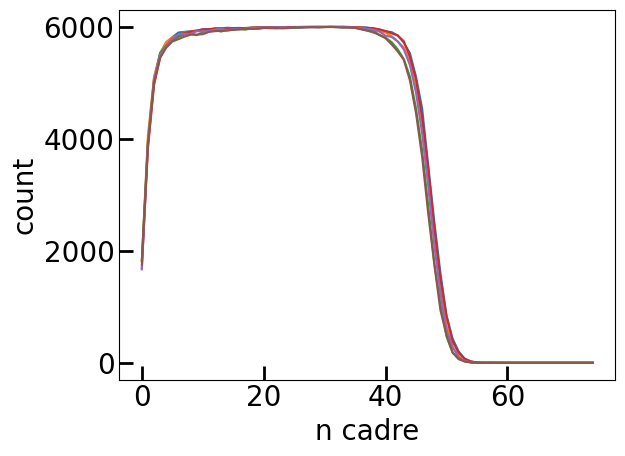

In [ ]:
fig=plt.figure()
for i in range(6):
    hist=hist_activ(data_all[i])
    plt.plot(hist['h'])
# count more 5 activation in cadre
plt.ylabel('count')
plt.xlabel('n cadre')
plt.savefig('drive/MyDrive/mosaic_hits/hist_activ.png',bbox_inches='tight')

In [ ]:
stop_cadre=75
n_cadre=pd.DataFrame(index=np.arange(0,stop_cadre,1),columns=['b'])
hist=pd.DataFrame({'h':np.zeros(stop_cadre)})
for j in range(6000):
    for i in range(stop_cadre):
        n_cadre['b'].loc[i]=np.count_nonzero(p[j,i,:,:])

    n_cadre[n_cadre['b']<=5]=0
    n_cadre[n_cadre['b']>5]=1
    hist['h']+=n_cadre['b']
hist

,h
0,1818.0
1,3976.0
2,5074.0
3,5524.0
4,5722.0
...,...
70,0.0
71,0.0
72,0.0
73,0.0


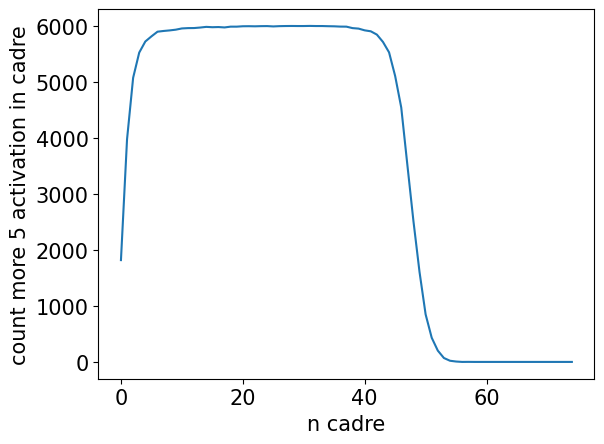

In [ ]:
fig=plt.figure()
plt.plot(hist['h'])
plt.ylabel('count more 5 activation in cadre')
plt.xlabel('n cadre')
plt.savefig('more_5_from_cadre.png')

Вывод: можно всего оставлять 50 кадров. Потому что все остальные бесполезные. В них ноль активаций ФЭУ. 

Ниже представлен график числа активаций в зависимости от кадра для 100 событий. Больше 

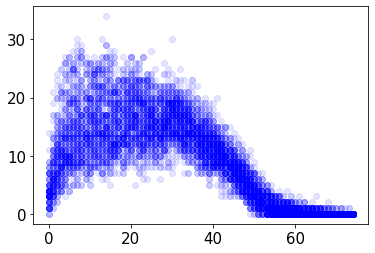

In [ ]:
fig=plt.figure()
for j in range(100):
  for i in range(stop_cadre):
    plt.scatter(i,np.count_nonzero(glob_array[j,i,:,:]),color='blue',alpha=0.1)
plt.savefig('nonzero_cadre.png')

# Исследовательские материалы

Как распределено число кадров, если взять дельту по времени 15 сек

(array([  43.,  395., 1145., 1513., 1319.,  771.,  500.,  197.,   90.,
          27.]),
 array([51.93333333, 55.04666667, 58.16      , 61.27333333, 64.38666667,
        67.5       , 70.61333333, 73.72666667, 76.84      , 79.95333333,
        83.06666667]),
 <BarContainer object of 10 artists>)

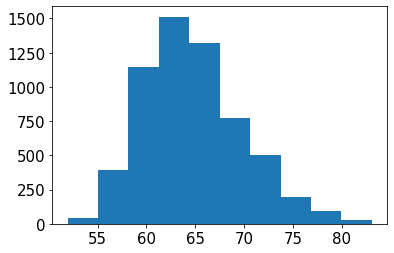

In [ ]:
fig=plt.figure()
plt.hist(l)

In [ ]:
dt=15  # ns
data=data.sort_values(['t'])
cadre=[]
for t in np.arange(data['t'].min(),data['t'].max(),dt): 
    d_data=data[(data['t']>t)&(data['t']<t+dt)]   # Отрезок массива в 15 сек
    df_n=pd.DataFrame({'n':np.arange(0,110,1)})    # Список из номеров ФЭУ

    d_n_count=d_data.groupby('n').agg({'n':['count']})['n']   # кол-во активаций и в каких ФЭУ
    df_n_count=pd.DataFrame({'n':d_n_count['count'].index,'c':d_n_count['count'].to_numpy()}) 

    df=df_n.merge(df_n_count,on='n',how='left').drop(columns='n').fillna(0)  # Список из активаций ФЭУ, номера ФЭУ по порядку (по индексу)

    cadre.append(df.to_numpy().reshape(-1))
    # print(max(df.to_numpy()),len(df_n_count))


[46.] 7
[53.] 17
[41.] 20
[46.] 20
[67.] 23
[77.] 26
[42.] 25
[30.] 22
[31.] 22
[23.] 21
[36.] 22
[18.] 24
[19.] 22
[15.] 30
[11.] 29
[10.] 28
[7.] 22
[9.] 22
[8.] 21
[6.] 20
[6.] 22
[5.] 21
[3.] 14
[3.] 19
[5.] 19
[6.] 21
[3.] 19
[3.] 15
[3.] 15
[4.] 16
[4.] 19
[5.] 20
[4.] 13
[3.] 18
[3.] 18
[4.] 17
[3.] 10
[3.] 12
[3.] 16
[2.] 18
[2.] 18
[3.] 11
[2.] 7
[2.] 8
[2.] 7
[2.] 4
[1.] 9
[1.] 3
[1.] 5
[2.] 8
[1.] 3
[2.] 2
[1.] 7
[0.] 0
[1.] 1
[1.] 1
[1.] 2
[0.] 0
[0.] 0
[0.] 0
[0.] 0
[1.] 1


In [ ]:
dr=pd.DataFrame({'n':np.arange(0,110,1)}) #,'c':np.zeros(110)})

dp=dnn.groupby('n').agg({'n':['count']})['n']
dpn=pd.DataFrame({'n':dp['count'].index,'c':dp['count'].to_numpy()})

df=dr.merge(dpn,on='n',how='left')
df.fillna(0)

,n,c
0,0,32.0
1,1,10.0
2,2,6.0
3,3,4.0
4,4,0.0
...,...,...
105,105,0.0
106,106,0.0
107,107,0.0
108,108,0.0
